Experiment E1-6:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 256
- EPOCHS = 15
- criterion = nn.BCEWithLogitsLoss()
- optimizer = Adam
- lr=1.0e-4

model:
- self.base_model(x)
- unfreeze 3 layers
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x) # (5120,1024)->Dropout(0.3)->Relu->(1024,1)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-6"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 15
config.LEARNING_RATE = 1e-4

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        for p in self.base_model[-3:].parameters():
            p.requires_grad = True

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280 * 2 * 2, 1024),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(1024, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/15
  Train Loss: 0.3731 | Train Acc: 0.8229
  Val Loss  : 0.3157 | Val Acc: 0.8553
  Train Precision: 0.8309 | Recall: 0.8482 | F1: 0.8395 | ROC AUC: 0.9113
  Train Confusion Matrix: TN=1259, FP=330, FN=290, TP=1621
  Val Precision: 0.9024 | Recall: 0.8242 | F1: 0.8615 | ROC AUC: 0.9436
  Val Confusion Matrix: TN=608, FP=73, FN=144, TP=675
2
Epoch 2/15
  Train Loss: 0.2354 | Train Acc: 0.9006
  Val Loss  : 0.2814 | Val Acc: 0.8840
  Train Precision: 0.9039 | Recall: 0.9152 | F1: 0.9095 | ROC AUC: 0.9657
  Train Confusion Matrix: TN=1403, FP=186, FN=162, TP=1749
  Val Precision: 0.9057 | Recall: 0.8791 | F1: 0.8922 | ROC AUC: 0.9562
  Val Confusion Matrix: TN=606, FP=75, FN=99, TP=720
3
Epoch 3/15
  Train Loss: 0.1794 | Train Acc: 0.9271
  Val Loss  : 0.2460 | Val Acc: 0.9067
  Train Precision: 0.9290 | Recall: 0.9383 | F1: 0.9336 | ROC AUC: 0.9800
  Train Confusion Matrix: TN=1452, FP=137, FN=118, TP=1793
  Val Precision: 0.8907 | Recall: 0.9451 | F1: 0.9171 | ROC AUC: 0.9694

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.373104,0.822857,0.830856,0.848247,0.839461,0.911311,"{'tn': 1259, 'fp': 330, 'fn': 290, 'tp': 1621}",0.315701,0.855333,0.902406,...,0.943631,"{'tn': 608, 'fp': 73, 'fn': 144, 'tp': 675}",1259,330,290,1621,608,73,144,675
1,0.235446,0.900571,0.903876,0.915228,0.909516,0.965718,"{'tn': 1403, 'fp': 186, 'fn': 162, 'tp': 1749}",0.281399,0.884000,0.905660,...,0.956157,"{'tn': 606, 'fp': 75, 'fn': 99, 'tp': 720}",1403,186,162,1749,606,75,99,720
2,0.179351,0.927143,0.929016,0.938252,0.933611,0.980015,"{'tn': 1452, 'fp': 137, 'fn': 118, 'tp': 1793}",0.246018,0.906667,0.890679,...,0.969351,"{'tn': 586, 'fp': 95, 'fn': 45, 'tp': 774}",1452,137,118,1793,586,95,45,774
3,0.126888,0.948286,0.948651,0.957091,0.952852,0.989818,"{'tn': 1490, 'fp': 99, 'fn': 82, 'tp': 1829}",0.310389,0.898000,0.934726,...,0.964883,"{'tn': 631, 'fp': 50, 'fn': 103, 'tp': 716}",1490,99,82,1829,631,50,103,716
4,0.099468,0.962857,0.964528,0.967556,0.966040,0.993910,"{'tn': 1521, 'fp': 68, 'fn': 62, 'tp': 1849}",0.283105,0.893333,0.927367,...,0.967401,"{'tn': 625, 'fp': 56, 'fn': 104, 'tp': 715}",1521,68,62,1849,625,56,104,715
5,0.085874,0.965143,0.966615,0.969649,0.968130,0.995332,"{'tn': 1525, 'fp': 64, 'fn': 58, 'tp': 1853}",0.286783,0.906000,0.905502,...,0.967479,"{'tn': 602, 'fp': 79, 'fn': 62, 'tp': 757}",1525,64,58,1853,602,79,62,757
6,0.054776,0.976857,0.978056,0.979592,0.978824,0.998191,"{'tn': 1547, 'fp': 42, 'fn': 39, 'tp': 1872}",0.325919,0.905333,0.925786,...,0.966189,"{'tn': 622, 'fp': 59, 'fn': 83, 'tp': 736}",1547,42,39,1872,622,59,83,736
7,0.068804,0.976286,0.977534,0.979069,0.978301,0.996747,"{'tn': 1546, 'fp': 43, 'fn': 40, 'tp': 1871}",0.305066,0.908000,0.907784,...,0.970847,"{'tn': 604, 'fp': 77, 'fn': 61, 'tp': 758}",1546,43,40,1871,604,77,61,758
8,0.043643,0.984000,0.985856,0.984825,0.985340,0.998781,"{'tn': 1562, 'fp': 27, 'fn': 29, 'tp': 1882}",0.316118,0.909333,0.922126,...,0.971047,"{'tn': 618, 'fp': 63, 'fn': 73, 'tp': 746}",1562,27,29,1882,618,63,73,746
9,0.039123,0.985143,0.985379,0.987441,0.986409,0.998835,"{'tn': 1561, 'fp': 28, 'fn': 24, 'tp': 1887}",0.361592,0.900000,0.909425,...,0.965703,"{'tn': 607, 'fp': 74, 'fn': 76, 'tp': 743}",1561,28,24,1887,607,74,76,743


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.315701  0.855333       0.902406    0.824176  0.861519    0.943631
1   0.281399  0.884000       0.905660    0.879121  0.892193    0.956157
2   0.246018  0.906667       0.890679    0.945055  0.917062    0.969351
3   0.310389  0.898000       0.934726    0.874237  0.903470    0.964883
4   0.283105  0.893333       0.927367    0.873016  0.899371    0.967401
5   0.286783  0.906000       0.905502    0.924298  0.914804    0.967479
6   0.325919  0.905333       0.925786    0.898657  0.912020    0.966189
7   0.305066  0.908000       0.907784    0.925519  0.916566    0.970847
8   0.316118  0.909333       0.922126    0.910867  0.916462    0.971047
9   0.361592  0.900000       0.909425    0.907204  0.908313    0.965703
10  0.525098  0.876667       0.945225    0.821734  0.879164    0.965530
11  0.412989  0.898000       0.898325    0.916972  0.907553    0.965731
12  0.391530  0.898667       0.891892    0.926740  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.098941,0.958838,0.960512,0.964521,0.962504,0.988299,0.348650,0.896489,0.914421,0.894831,0.903928,0.965149,1512.733333,76.266667,67.800000,1843.200000,611.866667,69.133333,86.133333,732.866667
std,0.096721,0.045467,0.043744,0.038657,0.041210,0.023253,0.076215,0.014611,0.016310,0.036120,0.015676,0.006893,85.313260,85.313260,73.873637,73.873637,15.873908,15.873908,29.582492,29.582492
min,0.028862,0.822857,0.830856,0.848247,0.839461,0.911311,0.246018,0.855333,0.890679,0.821734,0.861519,0.943631,1259.000000,13.000000,17.000000,1621.000000,586.000000,39.000000,45.000000,673.000000
25%,0.039822,0.955571,0.956590,0.962323,0.959446,0.991864,0.295924,0.895667,0.903954,0.876679,0.901421,0.965617,1505.500000,27.500000,25.000000,1839.000000,603.000000,57.500000,65.000000,718.000000
50%,0.054776,0.976857,0.978056,0.979592,0.978824,0.998191,0.316118,0.900000,0.909425,0.907204,0.908313,0.966297,1547.000000,42.000000,39.000000,1872.000000,608.000000,73.000000,76.000000,743.000000
75%,0.113178,0.984714,0.985618,0.986918,0.986008,0.998894,0.402259,0.906333,0.926577,0.920635,0.915174,0.968494,1561.500000,83.500000,72.000000,1886.000000,623.500000,78.000000,101.000000,754.000000
max,0.373104,0.990571,0.993172,0.991104,0.991364,0.999448,0.525098,0.909333,0.945225,0.945055,0.917062,0.971047,1576.000000,330.000000,290.000000,1894.000000,642.000000,95.000000,146.000000,774.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   15.000000  15.000000        15.000000     15.000000  15.000000   
mean     0.098941   0.958838         0.960512      0.964521   0.962504   
std      0.096721   0.045467         0.043744      0.038657   0.041210   
min      0.028862   0.822857         0.830856      0.848247   0.839461   
25%      0.039822   0.955571         0.956590      0.962323   0.959446   
50%      0.054776   0.976857         0.978056      0.979592   0.978824   
75%      0.113178   0.984714         0.985618      0.986918   0.986008   
max      0.373104   0.990571         0.993172      0.991104   0.991364   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     15.000000  15.000000  15.000000      15.000000   15.000000   
mean       0.988299   0.348650   0.896489       0.914421    0.894831   
std        0.023253   0.076215   0.014611       0.016310    0.036120   
min        0.911311   0.246018   0.855333    

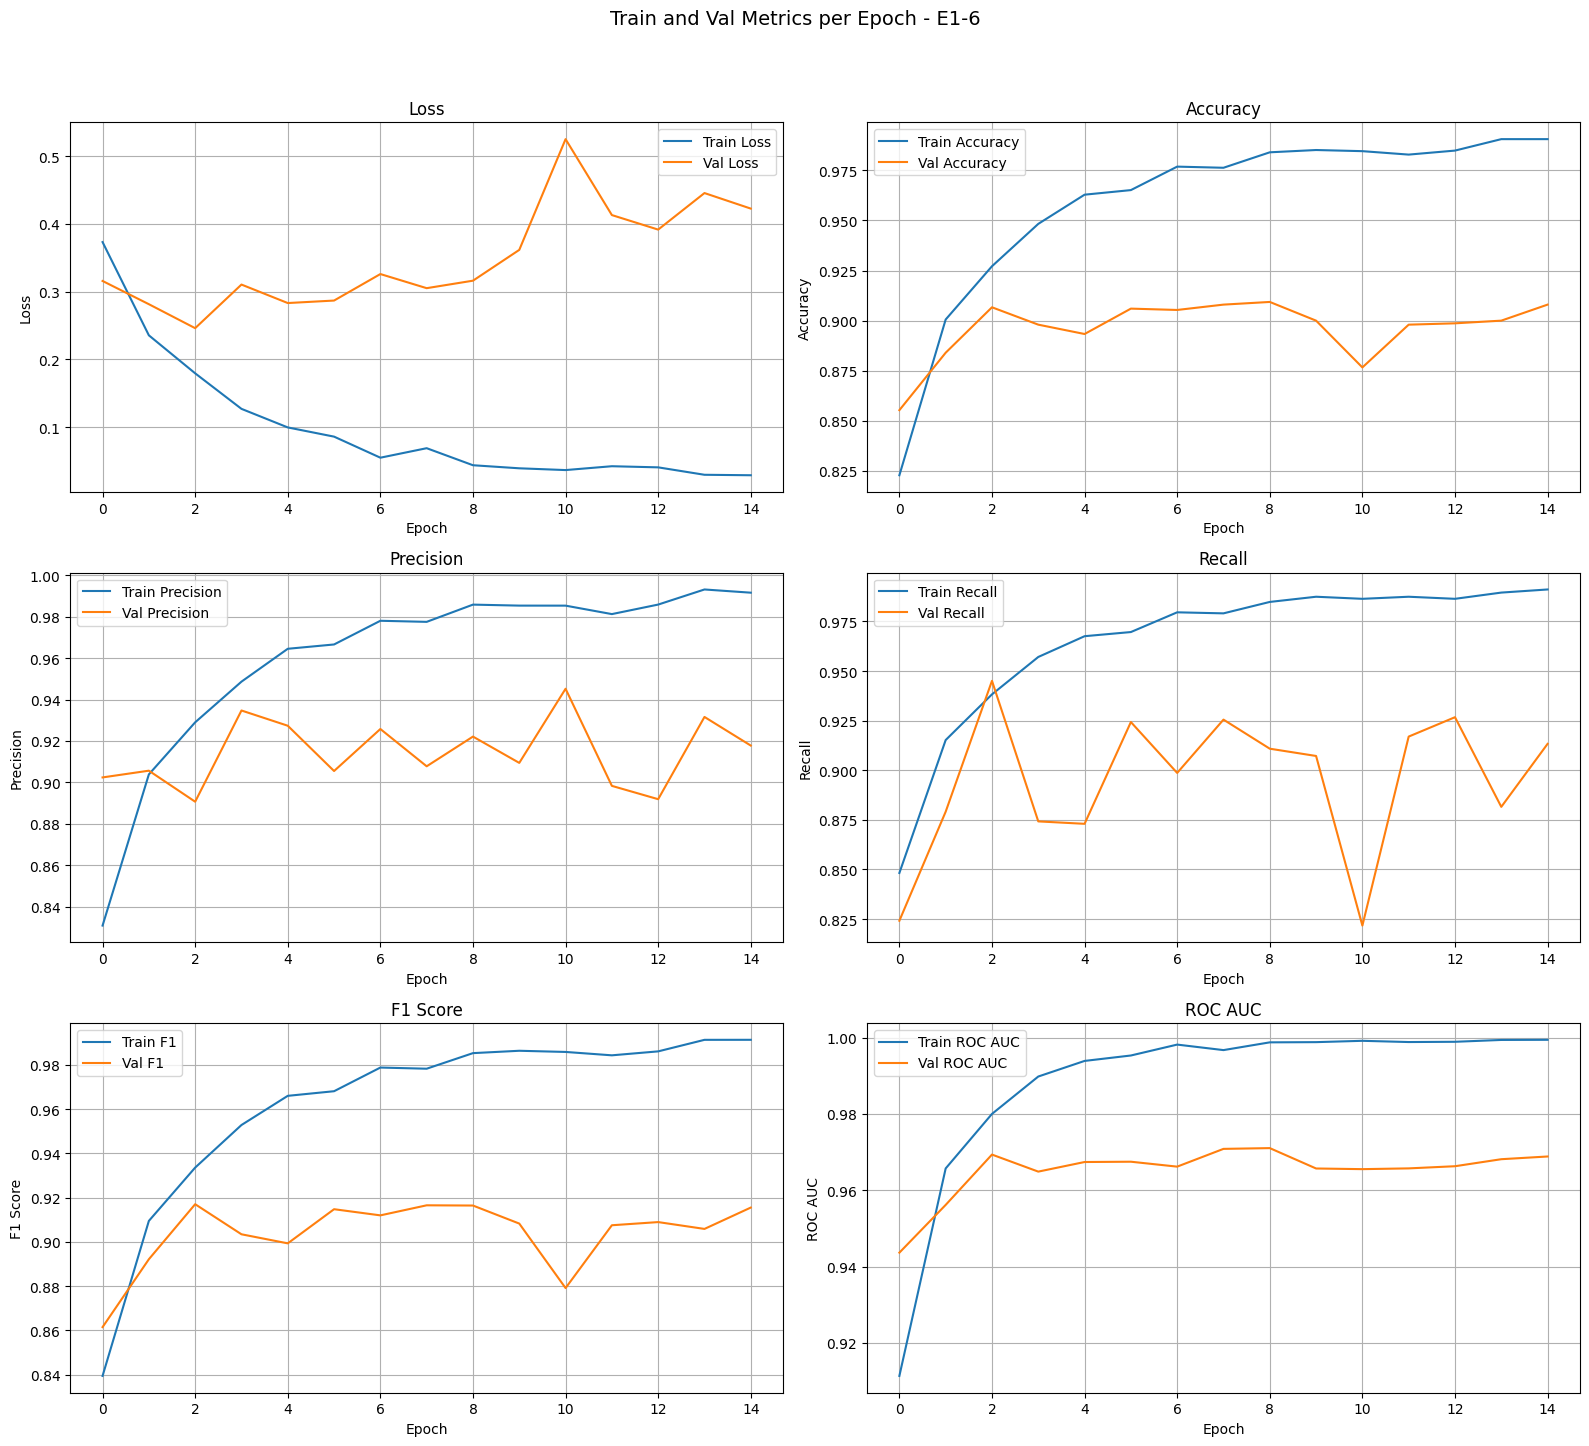

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,15.000000,15.000000,15.000000,15.000000
mean,1512.733333,76.266667,67.800000,1843.200000
std,85.313260,85.313260,73.873637,73.873637
min,1259.000000,13.000000,17.000000,1621.000000
25%,1505.500000,27.500000,25.000000,1839.000000
50%,1547.000000,42.000000,39.000000,1872.000000
75%,1561.500000,83.500000,72.000000,1886.000000
max,1576.000000,330.000000,290.000000,1894.000000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,15.000000,15.000000,15.000000,15.000000
mean,611.866667,69.133333,86.133333,732.866667
std,15.873908,15.873908,29.582492,29.582492
min,586.000000,39.000000,45.000000,673.000000
25%,603.000000,57.500000,65.000000,718.000000
50%,608.000000,73.000000,76.000000,743.000000
75%,623.500000,78.000000,101.000000,754.000000
max,642.000000,95.000000,146.000000,774.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)